# Gathering Culver City Yelp Data

In this notebook, I used Yelp's API to get information on businesses in Culver City. Yelp does not tell whether businesses are actually located in Culver City but gets relatively close. I did some data cleaning to remove places that are too far (e.g. Melrose, Playa Vista) and double check places with incorrect zip codes in order to filter the dataset to only show nearby businesses.


In [8]:
# Import libraries
import pandas as pd
import numpy as np

import json
import requests

import matplotlib.pyplot as plt
import folium

MY_API_KEY = ''


### Get businesses from Yelp Fusion API

There are <a href="https://www.yelp.com/developers/documentation/v3/get_started">different ways to call Yelp's API</a>, and I used the <a href="https://www.yelp.com/developers/documentation/v3/business_search">business search endpoint</a> to search for Culver City businesses. I found <a href="https://github.com/Yelp/yelp-fusion/blob/master/fusion/python/sample.py#L91">online examples</a> to help me transform the JSON response into a Pandas dataframe:

**Yelp Business Search Parameters**
* term (optional)
* location
* radius (search radius in meters, I used 2 miles or ~3250 meters given Culver City is relatively dense)
* categories (<a href="https://www.yelp.com/developers/documentation/v3/all_category_list"> see list of categories</a>)
* limit (max is 50, default is 20)
* offset (starting index)
* attributes (e.g. `hot_and_new`, `request_a_quote`)
* sort_by (e.g. `review_count`, `distance`)

The response is a dictionary with the following keys: `businesses`, `total`, `region`. The most important key is the `businesses` one.




In [211]:
# Call Yelp's API and return results in a dataframe
def search(api_key, location, radius, limit, offset, sort_by):
    """Query the Search API by a search location.
    Args:
        location (str): Search location passed to the API.
        limit (int): Number of entries returned by the API. Max is 50.
        offset (int): Offset index for the API results.
        sort_by (str): How Yelp sorts the results.
    Returns:
        dataframe: Pandas dataframe of JSON response from the request.
    """

    url = 'https://api.yelp.com/v3/businesses/search'

    headers = {
            'Authorization': 'Bearer {}'.format(api_key),
        }

    url_params = {
                    'location': location.replace(' ', '+').replace(',','%2C'),
                    'radius': radius,
                    'limit': limit,
                    'offset': offset_index,
                    'sort_by': sort_by
                }

    response = requests.get(url, headers=headers, params=url_params)
    return pd.DataFrame.from_dict(response.json()['businesses'])

# Create dataframe
df = pd.DataFrame()
for offset_index in np.arange(0, 1000, 50):
    df = df.append(search(MY_API_KEY, 
                          location='Culver City, CA', 
                          radius=3500,
                          limit=50, 
                          offset=offset_index, 
                          sort_by='review_count'))
# Reformat some columns
df[['latitude','longitude']] = df.coordinates.apply(pd.Series)
df[['address_1','address_2','address_3','city','zip_code','country','state','display_address']] = \
    df.location.apply(pd.Series)
df[['category_1', 'category_2', 'category_3']] = df.categories.apply(pd.Series)
df.category_1 = df.category_1.apply(pd.Series).title
df.category_2 = df.category_2.apply(pd.Series).title
df.category_3 = df.category_3.apply(pd.Series).title

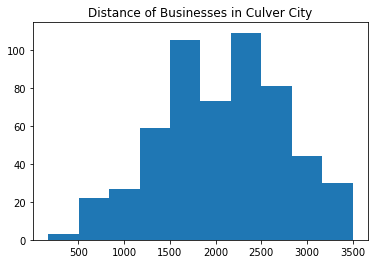

In [260]:
# Filter out more locations not in Culver City (some have wrong zips)

# df.groupby('zip_code').count()
# df[df.zip_code == '02713']
# df[df.zip_code == '90036']
# df[df.zip_code == '90048']
# df[df.zip_code == '90405']
# df[df.zip_code == '90094']
# df[df.zip_code == '90045']

culver_city_zips = ['90066', '90230', '90231', '90232', '90233', '90292']
extra_zips = ['02713', '44047', '90056', '90060', '93453', '90016', '90034', '']

df = df[df.zip_code.isin(culver_city_zips + extra_zips)]

# Limit distances from Culver City to under 3,500 meters (approximately 2.5 miles)
df = df[df.distance < 3500]
plt.hist(df.distance);
plt.title('Distance of Businesses in Culver City');

In [261]:
# Plot the Culver City region
yelp_map = folium.Map([34.0059338, -118.4265341]) 
for row in df.index:
    lat = df['latitude'].iloc[row]
    long = df['longitude'].iloc[row]
    marker = folium.Marker([lat, long])
    marker.add_to(yelp_map)
yelp_map

### Save results in .csv file

In [150]:
# Save dataframe as is
df.to_csv('yelp_culver_city_full_data.csv', index=False)

# Save ratings
df[['id', 'name', 'rating']].to_csv('yelp_culver_city_ratings.csv', index=False)

In [151]:
df = pd.read_csv('yelp_culver_city_full_data.csv')

### Get hierarchy of categories

Yelp's page provides a JSON file for its list of categories. Definitions are below:

<table>
    <tr><th>field name</th><th>data type</th><th>definition</th></tr>
    <tr><td>alias</td><td>string</td><td>Category Alias</td></tr>
    <tr><td>title</td><td>string</td><td>Title of this category</td></tr>
    <tr><td>parent_aliases</td><td>string</td><td>List of aliases of parent categories</td></tr>
    <tr><td>country_whitelist</td><td>string</td><td>Countries for which this category is whitelisted</td></tr>
    <tr><td>country_blacklist</td><td>string</td><td>Countries for which this category is blacklisted</td></tr>
</table>

My new data layout will consider levels, where the node (category) without parents will be level 1 and its descendants will add 1 more level for each generation. I will ignore whitelist and blacklist. 

In [10]:
# Clean categories
categories_df = pd.DataFrame()
for i in range(3):
    temp_df = df[['id','name','category_'+str(i+1)]]
    temp_df.columns = ['id','name','category']
    temp_df = temp_df.dropna()
    categories_df = categories_df.append(temp_df)

In [11]:
# Read Yelp's provided JSON file of all categories
with open('categories.json') as file:
    json_data = json.load(file)
categories = pd.DataFrame(json_data)

# Reformat parents columns
categories[['parent_1', 'parent_2', 'parent_3']] = categories.parents.apply(pd.Series)
categories_yelp = pd.DataFrame()
for i in range(3):
    temp_df = categories[['alias','title','parent_'+str(i+1)]]
    temp_df.columns = ['alias','title','parent']
    if i > 0:
        temp_df = temp_df.dropna()
    categories_yelp = categories_yelp.append(temp_df)

In [23]:
# Create a hierarchy by reading the JSON file
def create_hierarchy(dataframe, alias_name, title_name, parents_name):
    """Build a hierarchy by calling parents recursively.
    Args:
        dataframe (dataframe): Search location passed to the API.
        alias_name (str): Name of parents column in dataframe.
        title_name (str): Name of parents column in dataframe.
        parents_name (str): Name of parents column in dataframe.
    Returns:
        dataframe: Pandas dataframe 
    """
    
    def next_gen(dataset, mapping):
        """Add the parents as columns to the dataframe.
        Args:
            dataset (dataframe): Row of a dataframe object.
            mapping (dataframe): Lookup of parents.
        Returns:
            dataframe: Row of new dataframe.
        """
        
        index = dataset.shape[1]//3
        dataset = pd.merge(dataset, 
                          mapping, 
                          how='left', 
                          left_on ='parent_' + str(index), 
                          right_on='alias_1', 
                          suffixes=('_' + str(index),'_' + str(index+1)))

        new_labels = []
        for i in range(dataset.shape[1]//3):
                new_labels.append('alias_' + str(i+1))
                new_labels.append('title_' + str(i+1))
                new_labels.append('parent_' + str(i+1))
        dataset.columns = new_labels
        return dataset
                
    
    # Base Case: create the leaf
    df = dataframe[[alias_name, title_name, parents_name]]
    df.columns = ['alias_1', 'title_1', 'parent_1']
    mapping = df.copy()
    
    # Recursive Case: move categories down a level if they have parents
    while df[df['parent_' + str(df.shape[1]//3)].isna()].shape[0] != df.shape[0]:
        df = next_gen(df, mapping)
    return df

categories_X = create_hierarchy(dataframe=categories_yelp, 
                 alias_name='alias', 
                 title_name='title', 
                 parents_name='parent')

In [146]:
# Rearrange table of categories
new_x = pd.DataFrame(columns=['level_1', 'level_2', 'level_3', 'level_4'])        
for i in range(categories_X.shape[0]):
    row = categories_X.iloc[i]
    if type(row.parent_1) == type(0.0):
        row_temp = {'level_1': row.title_1}
    elif type(row.parent_2) == type(0.0):
        row_temp = {'level_1': row.title_2, 'level_2': row.title_1}
    elif type(row.parent_3) == type(0.0):
        row_temp = {'level_1': row.title_3, 'level_2': row.title_2, 'level_3': row.title_1}
    else: 
        row_temp = {'level_1': row.title_4, 'level_2': row.title_3, 'level_3': row.title_2, 'level_4': row.title_1}
    new_x = new_x.append(pd.DataFrame(data=row_temp, index=[0]))

# Save table as csv file
new_x.to_csv('yelp_categories.csv', index=False)